> ## TASK 3
-----

Begin by exploring the [instructor's notebook](https://github.com/nipunbatra/ml-teaching/blob/master/notebooks/siren.ipynb) that introduces the application of Random Fourier Features (RFF) for image reconstruction. Demonstrate the following applications using the cropped image from the notebook:

1.  Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) **[3 Marks]**


2. The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics:  **[1 Marks]**
    - RMSE on predicted v/s ground truth high resolution image
    - Peak SNR on predicted v/s ground truth high resolution image 

Follow the below steps to execute this task:
- Start with a 400x400 high-resolution image (the original image).
- Resize it to a 200x200 image (this will be your input image). You can use OpenCV's resize function or another library for this. Here’s a tutorial to help: [OpenCV Resize Image Tutorial](https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/#gsc.tab=0).
- Use Random Fourier Features (RFF) along with linear regression to learn a function based on the 200x200 image.
- Use the learned function to predict the pixel values for the 400x400 image. This means predicting the values for the pixels that fall between the existing pixels of the 200x200 image.
- Compare your predicted 400x400 image with the original 400x400 high-resolution image.
- Calculate the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the predicted image and the original high-resolution image.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [3]:
if os.path.exists('frog.jpg'):
    print('frog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/GettyImages-1191014275.jpg -O frog.jpg

frog.jpg exists


In [4]:
# Read in a image from torchvision
img = torchvision.io.read_image("frog.jpg")
print(img.shape)

torch.Size([3, 1661, 2500])


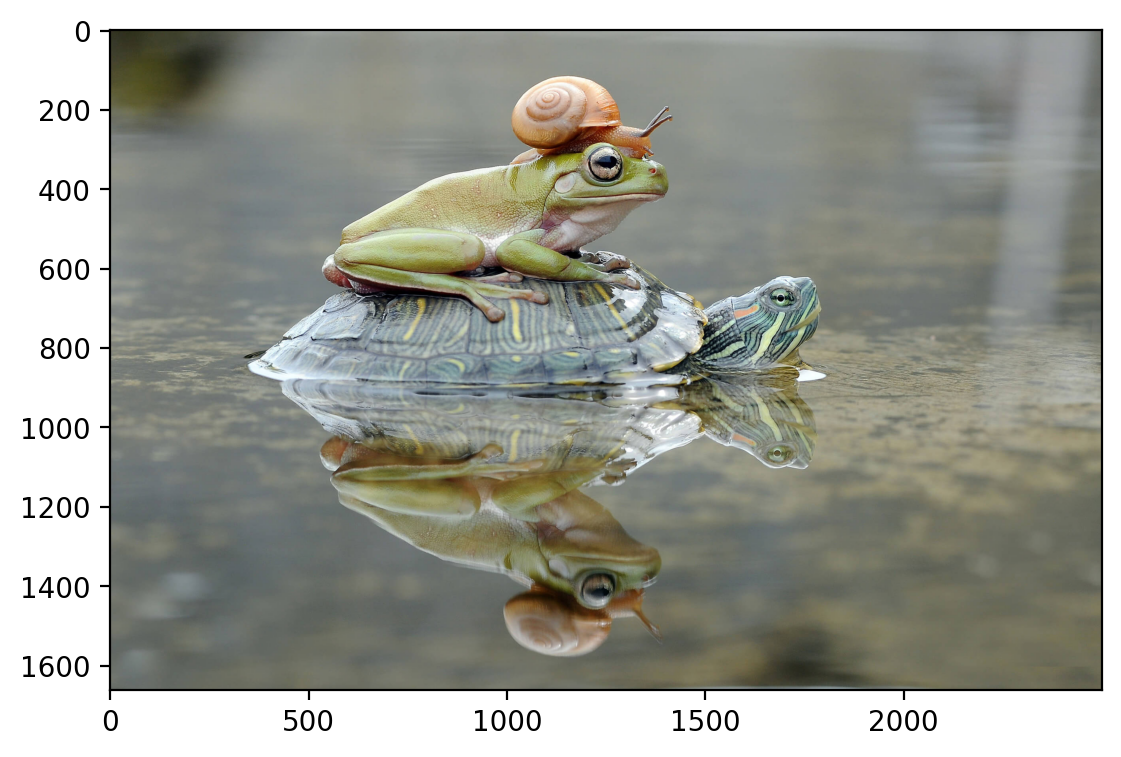

In [5]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [6]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img


MinMaxScaler()

In [7]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled, dtype=torch.float32)

In [8]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.2196, 0.2196, 0.2157,  ..., 0.4392, 0.4353, 0.4353],
         [0.2196, 0.2196, 0.2157,  ..., 0.4392, 0.4353, 0.4353],
         [0.2196, 0.2196, 0.2157,  ..., 0.4392, 0.4353, 0.4353],
         ...,
         [0.3922, 0.3882, 0.3843,  ..., 0.4078, 0.4078, 0.4078],
         [0.3922, 0.3882, 0.3843,  ..., 0.4078, 0.4078, 0.4078],
         [0.3922, 0.3882, 0.3843,  ..., 0.4000, 0.4000, 0.4000]],

        [[0.2039, 0.2039, 0.2000,  ..., 0.4471, 0.4431, 0.4431],
         [0.2039, 0.2039, 0.2000,  ..., 0.4471, 0.4431, 0.4431],
         [0.2039, 0.2039, 0.2000,  ..., 0.4471, 0.4431, 0.4431],
         ...,
         [0.4118, 0.4078, 0.4039,  ..., 0.4039, 0.4039, 0.4039],
         [0.4118, 0.4078, 0.4039,  ..., 0.4039, 0.4039, 0.4039],
         [0.4118, 0.4078, 0.4039,  ..., 0.4078, 0.4078, 0.4078]],

        [[0.1569, 0.1569, 0.1529,  ..., 0.4275, 0.4235, 0.4235],
         [0.1569, 0.1569, 0.1529,  ..., 0.4275, 0.4235, 0.4235],
         [0.1569, 0.1569, 0.1529,  ..., 0.4275, 0.4235, 0.

In [9]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 150, 900, 400, 400)
crop.shape

torch.Size([3, 400, 400])

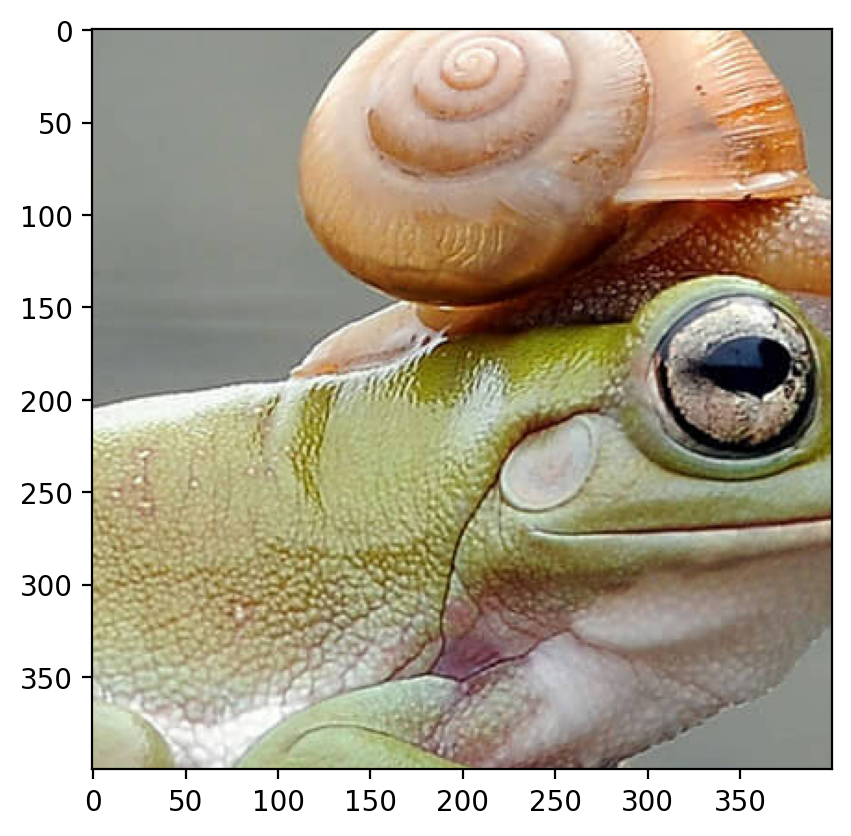

In [10]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [11]:
try:
    import cv2
except ImportError:
    %pip install opencv-python

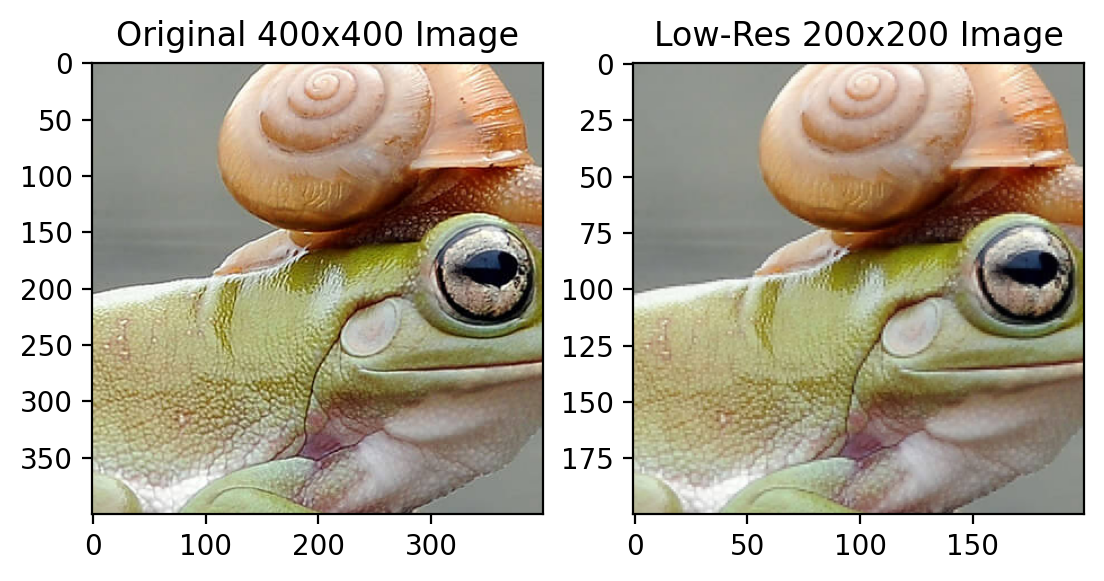

In [19]:
import cv2
crop_image = crop.to(device)

if isinstance(crop_image, torch.Tensor):
    # Rearrange to [height, width, channels] format for OpenCV
    crop_image_np = rearrange(crop_image, 'c h w -> h w c').cpu().numpy()

# Resize to 200x200 to simulate low-resolution image
low_res_frog = cv2.resize(crop_image_np, (200, 200), interpolation=cv2.INTER_AREA)

# Rearrange back to [channels, height, width] format for PyTorch
low_res_frog = rearrange(low_res_frog, 'h w c -> c h w')

# # Display original and resized (low-res) images
plt.subplot(1, 2, 1)
plt.imshow(rearrange(crop_image, 'c h w -> h w c').cpu().numpy(), cmap='gray')
plt.title('Original 400x400 Image')

plt.subplot(1, 2, 2)
plt.imshow(rearrange(low_res_frog, 'c h w -> h w c'), cmap='gray')
plt.title('Low-Res 200x200 Image')
plt.show()

In [18]:
# Get the dimensions of the image tensor
num_channels, height, width = low_res_frog.shape
print(num_channels, height, width)

3 200 200


In [27]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

low_res_frog_tensor = torch.Tensor(low_res_frog).to(device)

a, b = create_coordinate_map(low_res_frog_tensor)


tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]], device='mps:0')
tensor([[0.5529, 0.5725, 0.5569],
        [0.5529, 0.5725, 0.5569],
        [0.5529, 0.5725, 0.5490],
        ...,
        [0.5333, 0.5529, 0.5294],
        [0.5333, 0.5529, 0.5294],
        [0.5333, 0.5529, 0.5294]], device='mps:0')


In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge
import numpy as np

# Convert the low-res image to numpy for further processing
low_res_frog_np = low_res_frog.cpu().numpy()

# Prepare input: Convert 200x200 image to a coordinate grid
height, width = low_res_frog_np.shape[1], low_res_frog_np.shape[2]  # [channels, height, width]
coordinates = np.array([[i, j] for i in range(height) for j in range(width)])

# Flatten the image for output (only taking the first channel)
pixel_values = low_res_frog_np[0].flatten()

# Generate RFF features from the coordinate grid
def create_rff(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    return torch.tensor(rff.fit_transform(X), dtype=torch.float32).to(device)

rff_features = create_rff(coordinates, num_features=1000, sigma=1.0)

# Train a linear regression model to predict pixel values from RFF features
model = Ridge(alpha=1e-5)
model.fit(rff_features, pixel_values)


In [18]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)
